# Prepare

In [255]:
# machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

In [38]:
# general modules
import pandas as pd
import sqlite3 
import os
import numpy as np
import pandas_profiling
import seaborn as sns
import sqlite3 as sql
import hashlib

import pickle
import random

In [88]:
# variables
random_state = 42

temp_path = 'temp'
pckl_train = 'train_data'
pckl_test = 'test_data'

# Import

Import dataframes from pickle files

In [89]:
train_in = open(os.path.join("..",temp_path, pckl_train),'rb')
df_train = pickle.load(train_in)
train_in.close()

In [90]:
test_in = open(os.path.join("..",temp_path, pckl_test),'rb')
df_test = pickle.load(test_in)
test_in.close()

In [91]:
df_train.columns

Index(['order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name',
       'segment', 'city', 'state', 'country', 'postal_code', 'market',
       'region', 'product_id', 'category', 'sub-category', 'product_name',
       'sales', 'quantity', 'discount', 'profit', 'shipping_cost',
       'order_priority', 'returned', 'ship_delay'],
      dtype='object')

In [92]:
df_train

,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,...,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,returned,ship_delay
index,,,,,,,,,,,,,,,,,,,,,
27507,2012-12-27,2012-12-31,Standard Class,SP-20860,a7d03c30d416fc5f7d695b495884fdd7,Corporate,Murfreesboro,Tennessee,United States,37130.0,...,Accessories,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,72.74400,7,0.200,-12.73020,6.720,Medium,No,4
35511,2014-12-25,2015-01-01,Standard Class,JD-15895,1b2850c124acd1bc24237b4b5228b65e,Corporate,Oosterhout,North Brabant,Netherlands,NaN,...,Labels,"Smead File Folder Labels, Adjustable",23.73000,7,0.500,-21.00000,3.430,Low,No,7
9172,2012-05-08,2012-05-11,Second Class,AB-10600,6acab08bb2b385c8569adfd24730ee01,Corporate,Phnom Penh,Phnom Penh,Cambodia,NaN,...,Bookcases,"Dania Corner Shelving, Pine",617.10000,5,0.000,172.65000,36.380,Medium,No,3
31366,2011-06-30,2011-07-02,Second Class,GH-14410,1528a0a296f3ecf500753855ea9a21a5,Home Office,Lima,Lima (city),Peru,NaN,...,Chairs,"Hon Bag Chairs, Red",54.18000,3,0.400,-32.52000,4.919,Medium,Yes,2
24465,2013-06-23,2013-06-26,First Class,KW-16435,648a7c6f93ee0f453ee1378466a84ff8,Consumer,London,England,United Kingdom,NaN,...,Storage,"Fellowes Box, Wire Frame",50.62500,3,0.100,20.20500,8.570,Medium,No,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,2014-07-10,2014-07-14,Second Class,PS-18970,c90d076ff45727789cb1742f443028e1,Home Office,Petapa,Guatemala,Guatemala,NaN,...,Bookcases,"Bush Corner Shelving, Metal",246.90000,3,0.000,32.04000,28.644,Medium,No,4
44732,2014-11-26,2014-12-02,Standard Class,CK-12205,8fe3138a7ef91d7f8635f63b9d5331ad,Consumer,Panama City,Panama,Panama,NaN,...,Labels,"Hon Round Labels, Alphabetical",15.55200,6,0.400,1.99200,1.281,Medium,No,6
38158,2011-10-14,2011-10-18,Second Class,LR-17035,a916b8bb7b9fcce602d0808e2eef7979,Corporate,Agra,Uttar Pradesh,India,NaN,...,Labels,"Hon Shipping Labels, Alphabetical",44.76000,4,0.000,20.04000,2.690,High,No,4


# Transform

## Creating features

Order date to month

In [93]:
df_train["order_month"] = pd.DatetimeIndex(df_train["order_date"]).month
df_test["order_month"] = pd.DatetimeIndex(df_test["order_date"]).month

In [94]:
#df_train[["order_date","order_month"]].head()

## Feature selection

In [95]:
target_col = "ship_delay"

In [96]:
num_cols = ["sales", "quantity", "profit", "shipping_cost"]
std_cols = ["discount"]

nomi_cols = ["order_month", "segment", "market", "category", ]
ordi_cols = ["ship_mode", "order_priority"]


bin_cols = ["returned"]

unused_cols = ["order_date", "ship_date", "customer_id", "customer_name", "city", "state" ,"country", "postal_code", "region", "product_id",
               "sub-category", "product_name"]



In [97]:
# check column count

used_cols_len = len(num_cols)+len(nomi_cols)+len(ordi_cols)+len(bin_cols)+len(unused_cols)+len(std_cols)+1

print("Total cols:", len(df_train.columns))
print("Considered cols:", used_cols_len)

Total cols: 25
Considered cols: 25


# Sampling - for debugging only

In [60]:
df_train = df_train.sample(n=3000)
df_test = df_train.sample(n=1000)

In [61]:
len(df_train)

3000

## X y split

In [98]:
def split_x_y(df):
    y = np.array(df[target_col])
    return df, y

In [99]:
X_train, y_train = split_x_y(df_train)

In [100]:
X_test, y_test = split_x_y(df_test)

## Pipeline

In [101]:
ordinal_categories = [
    ["Standard Class", "Second Class", "First Class", "Same Day"],
    ["Low", "Medium", "High", "Critical"]
]

In [102]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

In [103]:
std_pipeline = Pipeline([
    ("simple_imp", SimpleImputer())
])

In [119]:
num_pipeline = Pipeline([
    ("simple_imp", SimpleImputer()),
    #("pol", PolynomialFeatures()),
])

In [105]:
nomi_pipeline = Pipeline([
    ("one_hot", OneHotEncoder()),
])

In [106]:
bin_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

In [127]:
# complex transform pipeline includes numeric + binary features
transform_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("nomi", nomi_pipeline, nomi_cols),
    ("ordi", ordinal_encoder, ordi_cols),
    ("bin", bin_pipeline, bin_cols),
    ("std", std_pipeline, std_cols)
])

In [128]:
# simple transform pipeline contains only categorical features
simple_transform_pipeline = ColumnTransformer([
    ("nomi", nomi_pipeline, nomi_cols),
    ("ordi", ordinal_encoder, ordi_cols),
])

---


## KNearest

First try with "complex" pipeline and 8 neighbors 

In [194]:
regression_pipeline = Pipeline([
    ("transform", transform_pipeline),
    ("knearest", KNeighborsRegressor(n_neighbors=8)),
])


In [195]:
model = regression_pipeline.fit(X_train, y_train)
model.score(X_train, y_train)

0.4966991687508868

In [214]:
model = regression_pipeline.fit(X_train, y_train)
model.score(X_test, y_test)

0.3499200215644279

Try with "simple" pipeline and 8 neighbors

In [198]:
regression_pipeline2 = Pipeline([
    ("transform", simple_transform_pipeline),
    ("knearest", KNeighborsRegressor(n_neighbors=8)),
])

In [201]:
model2 = regression_pipeline2.fit(X_train, y_train)
model2.score(X_train, y_train)

0.7454940313114891

In [202]:
model2 = regression_pipeline2.fit(X_train, y_train)
model2.score(X_test, y_test)

0.7051471071923816

### Hyperparameter tuning

In [206]:
# complex transformation
X_train_compl = transform_pipeline.fit_transform(X_train)
X_test_compl = transform_pipeline.fit_transform(X_test)

In [207]:
# simple transformation
X_train_simple = simple_transform_pipeline.fit_transform(X_train)
X_test_simple = simple_transform_pipeline.fit_transform(X_test)

In [208]:
n = []
train_simple = [] 
test_simple = []
train_complex = [] 
test_complex = []

In [209]:
def test_model(n_neighbors):
    
    n.append(n_neighbors)
    
    # complex
    model_complex = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train_compl, y_train)
    train_score = model_complex.score(X_train_compl, y_train)
    test_score = model_complex.score(X_test_compl, y_test)
    
    train_complex.append(train_score)
    test_complex.append(test_score)
    
    # simple
    model_simple = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train_simple, y_train)
    train_score = model_simple.score(X_train_simple, y_train)
    test_score = model_simple.score(X_test_simple, y_test)
    
    train_simple.append(train_score)
    test_simple.append(test_score)

In [210]:
# loop through hyperparameter (n neighbors)
test_range = 12

for i in range(test_range):
    test_model(i+1)

In [211]:
result = pd.DataFrame()
result.index = n
result["Score simple train"] = train_simple
result["Score simple test"] = test_simple
result["Score complex train"] = train_complex
result["Score complex test"] = test_complex
result


,Score simple train,Score simple test,Score complex train,Score complex test
1,0.592405,0.520608,1.000000,-0.100651
2,0.693085,0.629054,0.734056,0.176665
3,0.726785,0.666970,0.639521,0.261818
4,0.738765,0.686515,0.587409,0.302232
5,0.745910,0.696595,0.554919,0.321388
6,0.748062,0.702606,0.529775,0.333657
7,0.745889,0.703687,0.511850,0.341741
8,0.745494,0.705147,0.496699,0.349920
9,0.744342,0.706336,0.484967,0.354656
10,0.742752,0.705768,0.474171,0.356816


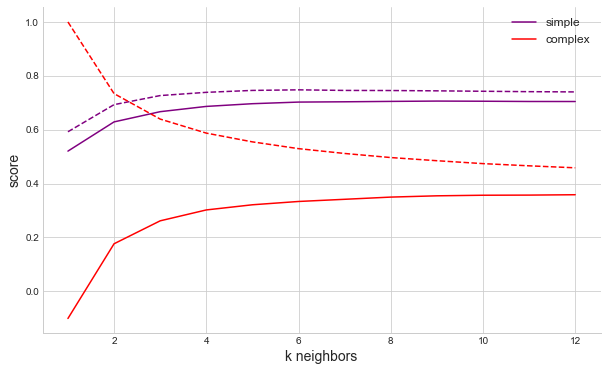

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.plot(n, train_simple, color="purple", linestyle="--")
plt.plot(n, test_simple, color="purple", label="simple")

plt.plot(n, train_complex, color="red", linestyle="--")
plt.plot(n, test_complex, color="red", label="complex")

plt.xlabel('k neighbors', size=14)
plt.ylabel('score', size=14)

plt.legend(fontsize=12)


In [248]:
import winsound
winsound.Beep(550,1000)

---

## Decision tree

In [275]:
decision_pipeline = Pipeline([
    ("transform", simple_transform_pipeline),
    ("dtree", DecisionTreeClassifier(max_depth=10)),
])


First try with simple transform pipeline (cat features) and depth of 3

In [276]:
model = decision_pipeline.fit(X_train, y_train)

In [277]:
model.score(X_train, y_train)

0.5050817498895271

In [278]:
model.score(X_test, y_test)

0.487211478477854

### Hyperparameter tuning

In [292]:
n = []
train_simple = []
test_simple = []
train_complex = []
test_complex = []

In [293]:
def test_model(max_depth):
    
    n.append(max_depth)
    
    # simple
    model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train_simple, y_train)
    train_score = model.score(X_train_simple, y_train)
    test_score = model.score(X_test_simple, y_test)
    
    train_simple.append(train_score)
    test_simple.append(test_score)

    # complex
    model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train_compl, y_train)
    train_score = model.score(X_train_compl, y_train)
    test_score = model.score(X_test_compl, y_test)
    
    train_complex.append(train_score)
    test_complex.append(test_score)
    

In [294]:
for i in range(20):
    test_model(i+1)

In [295]:
result = pd.DataFrame()
result.index = n
result["Score train simple"] = train_simple
result["Score test simple"] = test_simple
result["Score train complex"] = train_complex
result["Score test complex"] = test_complex

result


,Score train simple,Score test simple,Score train complex,Score test complex
1,0.378389,0.382408,0.378389,0.382408
2,0.430038,0.430209,0.430038,0.430209
3,0.454992,0.452745,0.454992,0.452745
4,0.478776,0.480661,0.478776,0.480661
5,0.480362,0.483702,0.480752,0.488459
6,0.482935,0.491344,0.482337,0.488459
7,0.486808,0.487601,0.488108,0.493918
8,0.490993,0.489863,0.494060,0.485340
9,0.497570,0.492046,0.501703,0.484014
10,0.505082,0.487289,0.511320,0.481285


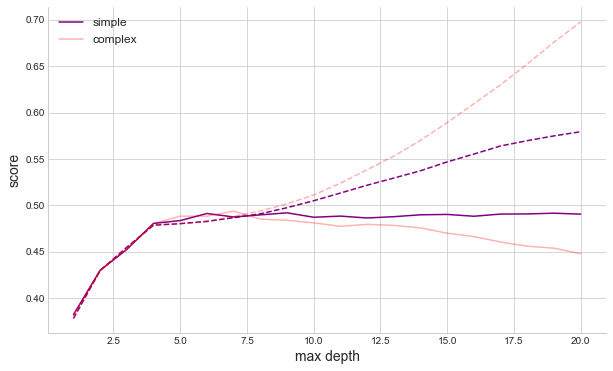

In [299]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.plot(n, train_simple, color="purple", linestyle="--")
plt.plot(n, test_simple, color="purple", label="simple")

plt.plot(n, train_complex, color="red", linestyle="--", alpha=0.3)
plt.plot(n, test_complex, color="red", label="complex", alpha=0.3)

plt.xlabel('max depth', size=14)
plt.ylabel('score', size=14)

plt.legend(fontsize=12)

In [249]:
y_test_predict = model.predict(X_test)

In [250]:
pd.DataFrame([y_test_predict]).transpose()

,0
0,4.250
1,5.250
2,5.500
3,5.000
4,4.125
...,...
12819,4.750
12820,3.500
12821,5.000
12822,3.000


In [251]:
df_check = X_test.copy() 

In [252]:
df_check["prediction"] = y_test_predict

In [253]:
df_check.loc[df_check["ship_delay"]!=df_check["prediction"]]

,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,...,sales,quantity,discount,profit,shipping_cost,order_priority,returned,ship_delay,order_month,prediction
index,,,,,,,,,,,,,,,,,,,,,
30040,2012-09-05,2012-09-11,Standard Class,CA-12055,d7f40cbb6597f62d85534ef6342c695e,Home Office,Houston,Texas,United States,77036.0,...,69.120,9,0.2,-14.6880,5.480,Medium,No,6,9,4.250
44906,2014-04-17,2014-04-23,Standard Class,MH-18025,0b13a87bdfb89e5bb4b2c7d188c81a66,Consumer,Hayange,Lorraine,France,NaN,...,31.200,1,0.0,4.0500,1.250,Medium,No,6,4,5.250
27274,2014-09-01,2014-09-06,Second Class,SS-20410,27ea858c3a7e3c037df97c0e1e7b8d5f,Consumer,Maracay,Aragua,Venezuela,NaN,...,97.272,2,0.4,-17.8480,6.841,Medium,No,5,9,5.500
35047,2013-11-11,2013-11-15,Second Class,LT-16765,92d453d65fa6b31840bc146955c2f8c9,Consumer,Bikaner,Rajasthan,India,NaN,...,31.140,3,0.0,2.4300,3.570,Medium,No,4,11,5.000
45715,2014-10-28,2014-10-31,Second Class,MA-17560,92adf7ff67aa85d6a74afadb0c095427,Home Office,Chicago,Illinois,United States,60610.0,...,7.056,3,0.2,2.2050,1.110,Medium,No,3,10,4.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29111,2012-04-04,2012-04-08,Second Class,BF-1275,8c17765580c101d5b5d8ef025d1d364f,Corporate,An Nasiriyah,Dhi Qar,Iraq,NaN,...,43.020,1,0.0,15.4800,5.920,High,No,4,4,3.250
25018,2011-05-11,2011-05-16,Standard Class,PG-18895,4c63c9a8552f33c37ca42d8227bd8bf3,Consumer,Fort Worth,Texas,United States,76106.0,...,100.792,1,0.2,6.2995,8.210,Medium,No,5,5,4.750
16992,2012-09-27,2012-09-29,Second Class,SS-20140,ffbcd7803fec65466870f0d49e286497,Corporate,Seattle,Washington,United States,98103.0,...,99.200,5,0.0,25.7920,16.360,Critical,No,2,9,3.500


In [ ]:
type(result_test)

In [ ]:
result_test

In [ ]:
model = KNeighborsRegressor(n_neighbors=4).fit(X_train_num, y_train)
y_train_predict = model.predict(X_train_num)
